In [1]:
import sys
sys.path.insert(0, "../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pydensecrf.densecrf as dcrf
from PIL import Image
import time

<h2> Swan

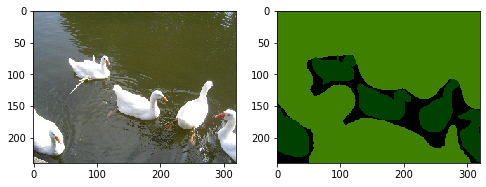

In [2]:
# Load the image and annotations
image = Image.open("../data/im1.ppm")
image = np.asarray(image).astype('uint8')

ann_rgb = Image.open("../data/anno1.ppm")
ann_rgb = np.asarray(ann_rgb).astype('uint8')

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(121)
ax.imshow(image)
ax = plt.subplot(122)
ax.imshow(ann_rgb)
plt.show()

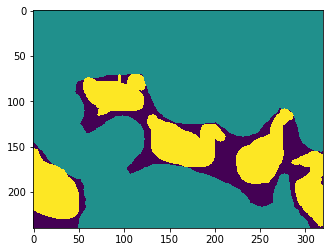

In [3]:
# Annotate the image
ann = np.zeros((ann_rgb.shape[0], ann_rgb.shape[1]))
for i in range(ann_rgb.shape[0]):
    for j in range(ann_rgb.shape[1]):
        if ann_rgb[i, j, :].tolist() == [0, 0, 0]:
            ann[i, j] = 0
        elif ann_rgb[i, j, :].tolist() == [64, 128, 0]:
            ann[i, j] = 1
        else:
            ann[i, j] = 2
plt.imshow(ann)

In [5]:
width = image.shape[1]
height = image.shape[0]
num_classes = 2

# Smoothness kernel pydensecrf object
d1 = dcrf.DenseCRF2D(width, height, 3)
d1.addPairwiseGaussian(sxy=(1, 1), compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

# Appearance kernel pydensecrf object
d2 = dcrf.DenseCRF2D(width, height, 3)
d2.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image, 
                       compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

In [6]:
def vectorInference(V, d):
    '''Perform parallel mixing on tensor V.
    Input:
        V: np.array of shape (k, n_pixel)
    Output:
        Vnew: mixed V of the same shape.
    '''
    Vnew = np.zeros_like(V)
    for k in range(V.shape[0]):
        Q_, tmp1_, tmp2_ = d.startInference()
        Q = np.ndarray((V.shape[1], 3), buffer=Q_, dtype=np.float32)
        Q[:] = 0
        Q[:,0] = V[k]
        d.vectorInference(Q_, tmp1_, tmp2_)
        Vnew[k] = Q[:,0]
    return Vnew

In [8]:
n_pixels = width * height
k = 50 # in practice, a small k works just fine, although theoretically \sqrt{2 * constraints} required
gt_prob = 0.75 # prior based on belief in annotations
s1 = 100 # weight on smoothness kernel
s2 = 200 # weight on appearance kernel

In [9]:
# Returns criterion value
def gc(_V, h, theta, s1=s1, s2=s2):
    '''
    _V: shape (k, n_pixels)
    h: shape (k, n_pixels)
    theta: scalar
    '''
    k = _V.shape[0]
    n_pixels = _V.shape[1]
    G = s1 * vectorInference(_V, d1) + s2 * vectorInference(_V, d2) # now, each column i in G is \sum_{j} v_j K[i, j]
    pairwise = np.sum(_V * G)
    pairwise = pairwise / 2 # because it is \sum_{i \neq j} (and assuming kernel approximation matrix is symmetric)
    pairwise = pairwise / 2 # because it is (1 / 2)\sum_{i \neq j} (delta(i,j) approximation as (1+vi^T vj))
    
    bias = 0
    bias = theta * np.sum(_V * h)
    
    return pairwise + bias

In [10]:
# Compute s_i's 
# r0 = \frac{\sum_l e_l}{L}
# b[l] = \frac{e_l - r0}{\sqrt{L-1/L}}
# These are the reference truth vectors on the simplex
b = np.zeros((num_classes, k))
b[np.arange(num_classes), np.arange(num_classes)] = 1
r0 = np.sum(b, axis=0) / num_classes
c = np.sqrt((num_classes - 1) / num_classes)
b = (b - r0[np.newaxis, :]) / c
print(b.shape) # (k, num_classes)

(2, 50)


In [11]:
# Unary potentials based on annotations
h = np.zeros((k, n_pixels))
for i in range(n_pixels):
    hi = 0
    for l in range(num_classes):
        if ann[i // width, i % width] == 0:
            p = 1 / num_classes
        else:
            if ann[i // width, i % width] == l + 1:
                p = gt_prob
            else:
                p = (1 - gt_prob) / (num_classes - 1)
        hi += np.log(p) * b[l, :]
    h[:, i] = hi

In [12]:
# Sample n vectors uniformly on unit sphere
def sample_unit_sphere(k, n):
    ret = np.random.normal(0, 1, size=(k, n))
    ret = ret / np.linalg.norm(ret, axis=0, keepdims=True)
    return ret

# Initialize V
V = np.zeros((k, n_pixels))
for i in range(n_pixels):
    print(i, end="\r")
    V[:, i] = sample_unit_sphere(k, 1).reshape(-1)

In [13]:
# Run the optimization
# Here, we are doing a form of gradient descent 
# since pydensecrf gives simultaneous coordinate descent updates
V_old = np.copy(V)
V_new = np.copy(V)

lr = 0.5
theta = 50
max_iters = 100
for iters in range(1, max_iters + 1):
    print("Iteration:", iters, " Criterion value =", gc(V_old, h, theta))
    G = s1 * vectorInference(V_old, d1) + s2 * vectorInference(V_old, d2)
    G = G / 2
    G = G + theta * h
    V_new = V_old + lr * G
    norms = np.linalg.norm(V_new, axis=0, keepdims=True)
    V_new = V_new / norms
    V_old = V_new

Iteration: 1  Criterion value = 930896.6716769835
Iteration: 2  Criterion value = 13474875.888072005
Iteration: 3  Criterion value = 20092611.39056004
Iteration: 4  Criterion value = 21218536.88022308
Iteration: 5  Criterion value = 21440483.059628204
Iteration: 6  Criterion value = 21498629.81672409
Iteration: 7  Criterion value = 21521021.687666953
Iteration: 8  Criterion value = 21532804.35684552
Iteration: 9  Criterion value = 21540260.35965778
Iteration: 10  Criterion value = 21545469.88241807
Iteration: 11  Criterion value = 21549320.507686332
Iteration: 12  Criterion value = 21552262.71264185
Iteration: 13  Criterion value = 21554567.066225886
Iteration: 14  Criterion value = 21556397.27756926
Iteration: 15  Criterion value = 21557875.06471532
Iteration: 16  Criterion value = 21559074.3904993
Iteration: 17  Criterion value = 21560057.17832516
Iteration: 18  Criterion value = 21560871.94441819
Iteration: 19  Criterion value = 21561546.548141435
Iteration: 20  Criterion value = 21

In [14]:
# Rounding procedure
def obtain_rounded_v(V, num_classes, S):
    n = V.shape[0]
    k = V.shape[1]
    r = sample_unit_sphere(num_classes, k)
    
    rounded_v = np.argmax(V @ r.T, axis=1)
    rounded_v_one_hot = np.zeros((n, num_classes))
    rounded_v_one_hot[np.arange(n), rounded_v] = 1
    
    # shape(num_classes): saying that r:i maps to S:j
    r_to_S = np.argmax(r @ S.T, axis=1)
    transformation_matrix = np.zeros((num_classes, num_classes))
    transformation_matrix[np.arange(num_classes), r_to_S] = 1
    rounded_v_one_hot = rounded_v_one_hot @ transformation_matrix
    rounded_v = np.argmax(rounded_v_one_hot, axis=1)
    
    return rounded_v

20632667.610031366
20632847.366059594


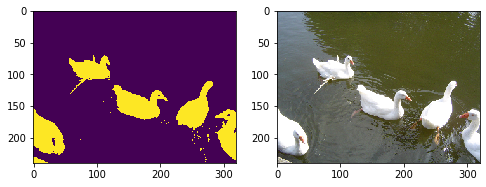

In [16]:
# Rounding
rounding_iters = 50
best_assignment = None
best_crit = -np.inf
for iters in range(rounding_iters):
    labels = obtain_rounded_v(V_new.T, num_classes, b)
        
    check_V = np.zeros((k, n_pixels))
    for i in range(n_pixels):
        check_V[int(labels[i]), i] = 1
    crit = gc(check_V, h, theta)
    if crit > best_crit:
        print(crit)
        best_crit = crit
        best_assignment = np.copy(labels)

reshaped = np.reshape(best_assignment, (height, width))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(121)
ax.imshow(reshaped)
ax = plt.subplot(122)
ax.imshow(image)
plt.show()

<h2> Bench

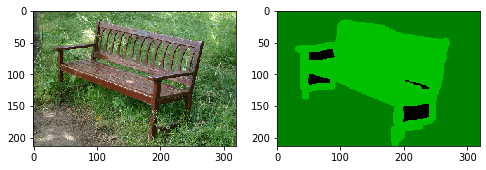

In [17]:
# Load the image and annotations
image = Image.open("../data/im2.ppm")
image = np.asarray(image).astype('uint8')

ann_rgb = Image.open("../data/anno2.ppm")
ann_rgb = np.asarray(ann_rgb).astype('uint8')

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(121)
ax.imshow(image)
ax = plt.subplot(122)
ax.imshow(ann_rgb)
plt.show()

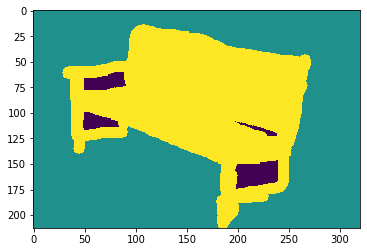

In [18]:
# Annotate the image
ann = np.zeros((ann_rgb.shape[0], ann_rgb.shape[1]))
for i in range(ann_rgb.shape[0]):
    for j in range(ann_rgb.shape[1]):
        if ann_rgb[i, j, :].tolist() == [0, 0, 0]:
            ann[i, j] = 0
        elif ann_rgb[i, j, :].tolist() == [0, 128, 0]:
            ann[i, j] = 1
        else:
            ann[i, j] = 2
plt.imshow(ann)

In [19]:
width = image.shape[1]
height = image.shape[0]
num_classes = 2

# Smoothness kernel pydensecrf object
d1 = dcrf.DenseCRF2D(width, height, 3)
d1.addPairwiseGaussian(sxy=(1, 1), compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

# Appearance kernel pydensecrf object
d2 = dcrf.DenseCRF2D(width, height, 3)
d2.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image, 
                       compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

In [20]:
n_pixels = width * height
k = 50 # in practice, a small k works just as fine, although theoretically \sqrt{2 * constraints} required
gt_prob = 0.75
s1 = 100
s2 = 200

In [21]:
# Compute s_i's 
# r0 = \frac{\sum_l e_l}{L}
# b[l] = \frac{e_l - r0}{\sqrt{L-1/L}}
b = np.zeros((num_classes, k))
b[np.arange(num_classes), np.arange(num_classes)] = 1
r0 = np.sum(b, axis=0) / num_classes
c = np.sqrt((num_classes - 1) / num_classes)
b = (b - r0[np.newaxis, :]) / c
print(b.shape) # (k, num_classes)

(2, 50)


In [22]:
h = np.zeros((k, n_pixels))
for i in range(n_pixels):
    hi = 0
    for l in range(num_classes):
        if ann[i // width, i % width] == 0:
            p = 1 / num_classes
        else:
            if ann[i // width, i % width] == l + 1:
                p = gt_prob
            else:
                p = (1 - gt_prob) / (num_classes - 1)
        hi += np.log(p) * b[l, :]
    h[:, i] = hi

In [23]:
# Initialize V
V = np.zeros((k, n_pixels))
for i in range(n_pixels):
    print(i, end="\r")
    V[:, i] = sample_unit_sphere(k, 1).reshape(-1)

In [24]:
V_old = np.copy(V)
V_new = np.copy(V)

lr = 0.5
theta = 50
max_iters = 100
for iters in range(1, max_iters + 1):
    print("Iteration:", iters, " Criterion value =", gc(V_old, h, theta))
    G = s1 * vectorInference(V_old, d1) + s2 * vectorInference(V_old, d2)
    G = G / 2
    G = G + theta * h
    V_new = V_old + lr * G
    norms = np.linalg.norm(V_new, axis=0, keepdims=True)
    V_new = V_new / norms
    V_old = V_new

Iteration: 1  Criterion value = 828709.8818672526
Iteration: 2  Criterion value = 10540149.8096449
Iteration: 3  Criterion value = 14545598.438540023
Iteration: 4  Criterion value = 16151626.383481156
Iteration: 5  Criterion value = 16958314.296440326
Iteration: 6  Criterion value = 17179784.300508652
Iteration: 7  Criterion value = 17259908.570176285
Iteration: 8  Criterion value = 17310533.32836271
Iteration: 9  Criterion value = 17353850.712012917
Iteration: 10  Criterion value = 17395077.333019573
Iteration: 11  Criterion value = 17435553.39740284
Iteration: 12  Criterion value = 17475413.367500503
Iteration: 13  Criterion value = 17514259.37164313
Iteration: 14  Criterion value = 17551427.527770802
Iteration: 15  Criterion value = 17586184.716909
Iteration: 16  Criterion value = 17617900.380890578
Iteration: 17  Criterion value = 17646162.367686346
Iteration: 18  Criterion value = 17670819.37330709
Iteration: 19  Criterion value = 17691955.17773317
Iteration: 20  Criterion value =

15698522.038686397
17119510.81428516
17352041.97033656


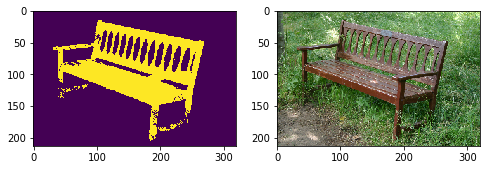

In [26]:
# Rounding
rounding_iters = 50
best_assignment = None
best_crit = -np.inf
for iters in range(rounding_iters):
    labels = obtain_rounded_v(V_new.T, num_classes, b)
        
    check_V = np.zeros((k, n_pixels))
    for i in range(n_pixels):
        check_V[int(labels[i]), i] = 1
    crit = gc(check_V, h, theta)
    if crit > best_crit:
        print(crit)
        best_crit = crit
        best_assignment = np.copy(labels)

reshaped = np.reshape(best_assignment, (height, width))

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(121)
ax.imshow(reshaped)
ax = plt.subplot(122)
ax.imshow(image)
plt.show()